The Palmer penguins data used in this blog post was collected by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station](https://www.nsf.gov/geo/opp/support/palmerst.jsp), which is a member of [Long Term Ecological Research Network](https://lternet.edu). The data contains physical measurements of three penguin species: Adelie, Chinstrap, and Gentoo.

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as plt
from matplotlib.patches import Patch
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [2]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN
3,PAL0910,146,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,"Adult, 1 Egg Stage",N82A2,Yes,11/16/09,39.0,18.7,185.0,3650.0,MALE,9.22033,-26.03442,NaN
4,PAL0708,24,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N85A2,No,11/28/07,50.6,19.4,193.0,3800.0,MALE,9.28153,-24.97134,NaN


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [4]:
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,41.1,17.5,190.0,3900.0,8.94365,-26.06943,0,1,0,1,0,1,0,1
270,45.4,14.6,211.0,4800.0,8.24515,-25.46782,1,0,0,1,0,1,1,0
271,36.2,17.2,187.0,3150.0,9.04296,-26.19444,0,0,1,1,1,0,1,0
272,50.0,15.9,224.0,5350.0,8.20042,-26.39677,1,0,0,1,0,1,0,1


### Explore (Tables and Plots)

In [5]:
# Show species by island 
train.groupby(['Species', 'Island'])['Region'].agg('count')

Species                                    Island   
Adelie Penguin (Pygoscelis adeliae)        Biscoe        35
                                           Dream         41
                                           Torgersen     42
Chinstrap penguin (Pygoscelis antarctica)  Dream         56
Gentoo penguin (Pygoscelis papua)          Biscoe       101
Name: Region, dtype: int64

This table shows the penguin species and the islands that they were found in. The results show that the Adelie penguins were found in all three islands while the Chinstrap penguins and the Gentoo penguins were found in Dream Island and Biscoe Island, respectively. This may be a good feature to train our model with because we can eliminate penguins depending on which island they were found in. For example, if a penguin were to be found in Torgersen Island, then there is a 100% chance it would be an Adelie penguin based on the table above. If a penguin were to be found in Biscoe Island, then it could either be an Adelie penguin or a Gentoo penguin but not a Chinstrap penguin.

In [6]:
# Shown species by average culmen length, culmen depth, flipper length, and body mass
train.groupby(["Species", "Sex"])[["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)",
                                  "Body Mass (g)"]].mean()

Culmen Length (mm)  \
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE           37.100000   
                                          MALE             40.458182   
Chinstrap penguin (Pygoscelis antarctica) FEMALE           46.424138   
                                          MALE             51.185185   
Gentoo penguin (Pygoscelis papua)         .                44.500000   
                                          FEMALE           45.600000   
                                          MALE             49.592593   

                                                  Culmen Depth (mm)  \
Species                                   Sex                         
Adelie Penguin (Pygoscelis adeliae)       FEMALE          17.645614   
                                          MALE            19.116364   
Chinstrap penguin (Pygoscelis antarctica) FEMALE          17.641379   
                                          MALE            19.303704   
Gentoo penguin (Pygoscelis papua)         .               15.700000   
                                          FEMALE          14.242857   
                                          MALE            15.687037   

                                                  Flipper Length (mm)  \
Species                                   Sex                           
Adelie Penguin (Pygoscelis adeliae)       FEMALE           187.719298   
                                          MALE             192.690909   
Chinstrap penguin (Pygoscelis antarctica) FEMALE           191.551724   
                                          MALE             199.666667   
Gentoo penguin (Pygoscelis papua)         .                217.000000   
                                          FEMALE           212.928571   
                                          MALE             221.462963   

                                                  Body Mass (g)  
Species                                   Sex                    
Adelie Penguin (Pygoscelis adeliae)       FEMALE    3337.280702  
                                          MALE      4020.454545  
Chinstrap penguin (Pygoscelis antarctica) FEMALE    3514.655172  
                                          MALE      3936.111111  
Gentoo penguin (Pygoscelis papua)         .         4875.000000  
                                          FEMALE    4677.976190  
                                          MALE      5502.314815

This table organizes the average culmen length, culmen depth, flipper length, and body mass by penguin species. The results indicate that the penguin species with the highest average culmen length and depth by sex is the Chinstrap penguin. This can be a useful feature to train the model with because we can label the penguin with the greatest culmen length and depth as the Chinstrap penguin followed by the Gentoo penguin.

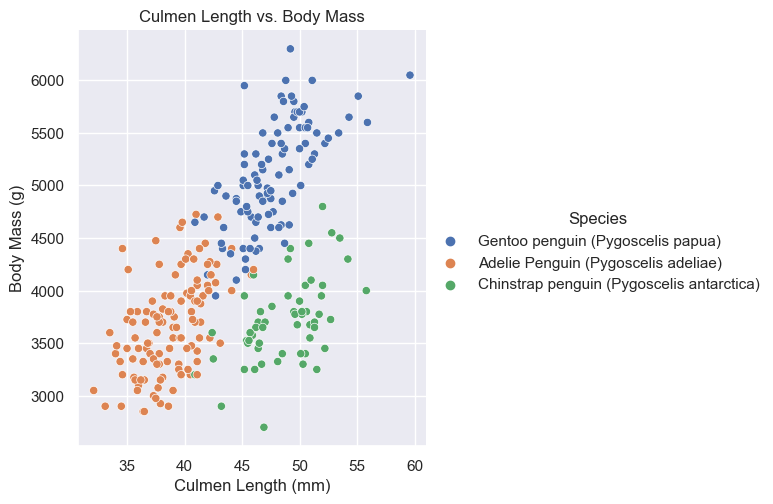

In [7]:
# Create plot 
sns.set_theme()

sns.relplot(data = train, x = "Culmen Length (mm)", y = "Body Mass (g)", hue = "Species").set(
    title="Culmen Length vs. Body Mass")

#sns.relplot(data = train, x = "Culmen Depth (mm)", y = "Body Mass (g)", hue = "Species").set(
#    title="Culmen Depth vs. Body Mass")

#sns.relplot(data = train, x = "Flipper Length (mm)", y = "Body Mass (g)", hue = "Species").set(
#    title="Flipper Length vs. Body Mass")

In this experiment, I plotted body mass against culmen length for each penguin species. Based on the plot,  we can see that Adelie penguins tend to have the smallest body mass as well as the smallest culmen length. Gentoo penguins generally have the same culmen length as Chinstrap penguins but Gentoo penguins are larger in terms of body mass.

### Model (Choosing Features)

Here, I use the code provided in the blog post guide to help me select the most useful features. I am using logistic regression, decision tree classifier, and random forest classifier to see which features result in a 1.0 accuracy.

In [8]:
# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

LR = LogisticRegression()
DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier()

##### Logistic Regression

In [9]:
# Logistic Regression
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    print(cols)
    LR.fit(X_train[cols], y_train)
    print(LR.score(X_train[cols], y_train))

['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']
0.96484375
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Flipper Length (mm)']
0.92578125
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Body Mass (g)']
0.921875
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.80078125
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Body Mass (g)']
0.7890625
['Clutch Completion_No', 'Clutch Completion_Yes', 'Flipper Length (mm)', 'Body Mass (g)']
0.6640625
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
0.99609375
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Flipper Length (mm)']
0.95703125
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)']
0.91796875
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.796875
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Body Mass (g)']
0.7

##### Decision Tree Classifier

In [10]:
# Decision Tree Classifier
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    print(cols)
    DTC.fit(X_train[cols], y_train)
    print(DTC.score(X_train[cols], y_train))

['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Flipper Length (mm)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Body Mass (g)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.98046875
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Body Mass (g)']
0.9921875
['Clutch Completion_No', 'Clutch Completion_Yes', 'Flipper Length (mm)', 'Body Mass (g)']
0.97265625
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Flipper Length (mm)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.9765625
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Body Mass (g)']
0.99609375
['Sex_FEMALE', 'Sex_MALE', 'Fl

##### Random Forest Classifier

In [11]:
# Random Forest Classifier
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    print(cols)
    RFC.fit(X_train[cols], y_train)
    print(RFC.score(X_train[cols], y_train))

['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Flipper Length (mm)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Body Mass (g)']
1.0
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.98046875
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Body Mass (g)']
0.9921875
['Clutch Completion_No', 'Clutch Completion_Yes', 'Flipper Length (mm)', 'Body Mass (g)']
0.96875
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Flipper Length (mm)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)']
1.0
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Flipper Length (mm)']
0.9765625
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Body Mass (g)']
0.99609375
['Sex_FEMALE', 'Sex_MALE', 'Flipp

I will be using these features of the decision tree classifier: 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Body Mass (g)' because they give us in 1.0 accuracy. Below is the proof that the score of the decision tree classifier using these features results in 1.0.

In [12]:
# Accuracy using Decision Tree Classifier on features 'cols'
cols = ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Body Mass (g)']
DTC.fit(X_train[cols], y_train)
print("Accuracy: " + str(DTC.score(X_train[cols], y_train)))

Accuracy: 1.0


### Evaluate and Testing

In [13]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
cols = ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Body Mass (g)']

DTC_score = DTC.score(X_test[cols], y_test)
print("Score on test data using Decision Tree Classifier: " + str(DTC_score))

Score on test data using Decision Tree Classifier: 0.9558823529411765


In [26]:
# Helper function for plotting (from blog post guide)
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (10, 5))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["blue", "green", "red"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
    
    # Titles for the plots
    axarr[0].set_title('Biscoe Islands')
    axarr[1].set_title('Dream Island')
    axarr[2].set_title('Torgersen Island')
      
    plt.tight_layout()

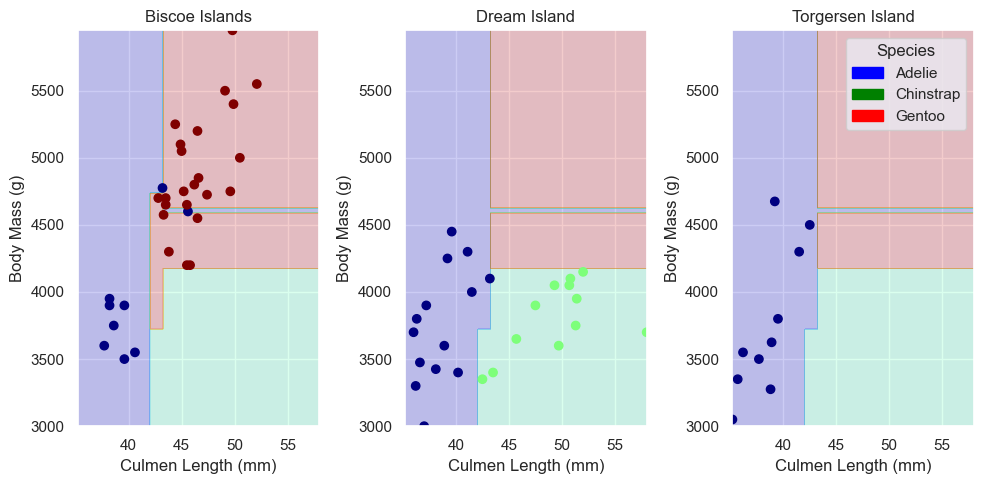

In [27]:
# Plot Culmen Length vs. Body Mass by different island
cols = ['Culmen Length (mm)', 'Body Mass (g)','Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
DTC.fit(X_test[cols], y_test)

plot_regions(DTC, X_test[cols], y_test)